In [2]:
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from collections import defaultdict
import random

similarity_matrix = np.array([
    [1.0, 0.8, 0.6, 0.2, 0.1, 0.4],
    [0.8, 1.0, 0.7, 0.3, 0.2, 0.5],
    [0.6, 0.7, 1.0, 0.4, 0.3, 0.6],
    [0.2, 0.3, 0.4, 1.0, 0.8, 0.7],
    [0.1, 0.2, 0.3, 0.8, 1.0, 0.9],
    [0.4, 0.5, 0.6, 0.7, 0.9, 1.0],
])

genes = ["gene1", "gene2", "gene3", "gene4", "gene5", "gene6"]

# Convert similarity to distance
distance_matrix = 1 - similarity_matrix
distance_matrix = (distance_matrix + distance_matrix.T) / 2  # Ensure symmetry
np.fill_diagonal(distance_matrix, 0)  # Set diagonal to zero
distance_matrix = np.round(distance_matrix, 3)  # Fix floating-point issues
condensed_matrix = squareform(distance_matrix)

In [3]:
condensed_matrix

array([0.2, 0.4, 0.8, 0.9, 0.6, 0.3, 0.7, 0.8, 0.5, 0.6, 0.7, 0.4, 0.2,
       0.3, 0.1])

In [9]:
from typing import Dict, Tuple, List, Union, Optional

import numpy as np
import scipy as sp
import pandas as pd

from fastcluster import linkage
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.cluster.hierarchy import to_tree, ClusterNode, dendrogram
from scipy.spatial.distance import squareform

z = linkage(condensed_matrix)
print(z)
z1 = sch.linkage(condensed_matrix, method="average")
print(z1)

[[4.  5.  0.1 2. ]
 [0.  1.  0.2 2. ]
 [3.  6.  0.2 3. ]
 [2.  7.  0.3 3. ]
 [8.  9.  0.4 6. ]]
[[4.         5.         0.1        2.        ]
 [0.         1.         0.2        2.        ]
 [3.         6.         0.25       3.        ]
 [2.         7.         0.35       3.        ]
 [8.         9.         0.66666667 6.        ]]


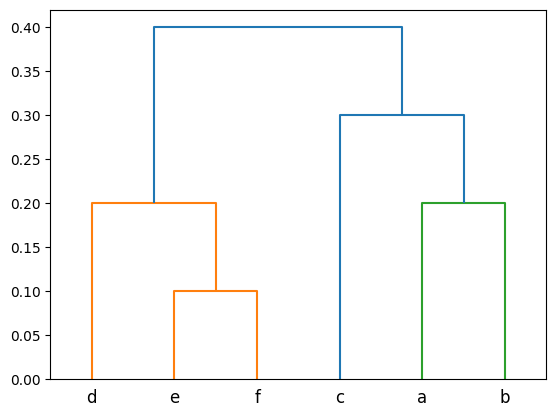

In [11]:
from string import ascii_lowercase
dend = dendrogram(z, leaf_label_func=lambda x: ascii_lowercase[x])

In [23]:
def safe_name(name):
    """ Ensure names are quoted if needed """
    if any(c in name for c in "(),:;"):
        return f"'{name}'"  # Quote names if they contain special characters
    return name

def linkage_to_newick(Z, labels):
    """ Convert linkage matrix to Newick format """
    tree, _ = sch.to_tree(Z, rd=True)  # Extract the tree object

    def build_newick(node):
        if node is None:
            return ""

        if node.left is None and node.right is None:
            return f"{labels[node.id]}:{max(node.dist, 0.001):.5f}"  # Avoid zero distance

        left_subtree = build_newick(node.left)
        right_subtree = build_newick(node.right)
        return f"({left_subtree},{right_subtree}):{max(node.dist, 0.001):.5f}"  # Ensure valid distance

    return build_newick(tree) + ";"

newick_str = linkage_to_newick(z, genes)
print(newick_str)

None
None
None
None
None
None
((gene4:0.00100,(gene5:0.00100,gene6:0.00100):0.10000):0.20000,(gene3:0.00100,(gene1:0.00100,gene2:0.00100):0.20000):0.30000):0.40000;


In [19]:
tree, _ = sch.to_tree(z, rd=True)

In [20]:
print(tree)

In [24]:
def _scipy_tree_to_newick_list(node: ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str]) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        newick.append(f'):{parentdist - node.dist}')
    else:
        newick.append(');')
    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names)
    newick.append('(')
    return newick


def to_newick(tree: ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names)
    return ''.join(newick_list[::-1])

In [25]:
T = to_tree(z, rd=False)
to_newick(T, ascii_lowercase)

'(((b:0.2,a:0.2):0.09999999999999998,c:0.3):0.10000000000000003,((f:0.1,e:0.1):0.1,d:0.2):0.2);'

In [29]:
from ete3 import ClusterTree, TreeStyle
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations


tree = ClusterTree('(A:0.1,B:0.2,(C:0.3,D:0.4):0.5);')
leaves = tree.get_leaf_names()
ts = TreeStyle()
ts.show_leaf_name=True
ts.show_branch_length=True
ts.show_branch_support=True

idx_dict = {'A':0,'B':1,'C':2,'D':3}
idx_labels = [idx_dict.keys()[idx_dict.values().index(i)] for i in range(0, len(idx_dict))]

#just going through the construction in my head, this is what we should get in the end
my_link = [[0,1,0.3,2],
        [2,3,0.7,2],
        [4,5,1.0,4]]

my_link = np.array(my_link)


dmat = np.zeros((4,4))

for l1,l2 in combinations(leaves,2):
    d = tree.get_distance(l1,l2)
    dmat[idx_dict[l1],idx_dict[l2]] = dmat[idx_dict[l2],idx_dict[l1]] = d

print ('Distance:')
print (dmat)


schlink = sch.linkage(scipy.spatial.distance.squareform(dmat),method='average',metric='euclidean')

print ('Linkage from scipy:')
print (schlink)

print ('My link:')
print (my_link)

print ('Did it right?: ', schlink == my_link)

dendro = sch.dendrogram(my_link,labels=idx_labels)
plt.show()

tree.show(tree_style=ts)

AttributeError: 'dict_values' object has no attribute 'index'

In [28]:
!pip3 install ete2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 1.5 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-bmf9_j18/ete2_846608d939974b7f84f37c8b08bd3812/setup.py", line 90
          print "Installing ETE (A python Environment for Tree Exploration)."
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an

In [48]:
import pandas as pd
location = "/mnt/c/Users/Saurav Baral/Desktop/20.RERConverge_trimmed/unTrimmed/3.For_tree"
# print("AA")
diapause = pd.read_csv(f"{location}/correlation_2_with_annotation.csv")
diapause = diapause[diapause["p.adj"] < 0.1]
diapause = diapause[diapause["Rho"] > 0.2]
diapause = diapause.rename(columns={"p.adj": "p_adj"})
output = "Busco_name,Rho,p_adj,Annotation"
# print(diapause)
for row in diapause.itertuples():
    # print(row._1.split("_")[0])
    # print(row.p.adj)
    output += f'\n{row._1.split("_")[0]},{row.Rho},{row.p_adj},{row.Pref_name}'
with open(f"{location}/significant_rho_rerconverge.csv", 'w') as out_file:
    out_file.write(output)
print(output)

Busco_name,Rho,p_adj,Annotation
12510at7088,0.343231833583301,0.0422820960860431,CHMP1B
2331at7088,0.270225798787778,0.0760593937345061,CNGA2
4043at7088,0.340828776940531,0.0624374074828578,ACAT1
5679at7088,0.255652772807683,0.0760593937345061,5679at7088
8751at7088,0.344435314882768,0.0794573840581532,8751at7088
5159at7088,0.313564469285874,0.0473474499449283,PDCD6IP
period.fas.ClipKIT,0.274979808700773,0.0346883475213,period
